In [1]:
import pandas as pd
import numpy as np

from skimage import io
from datetime import timedelta
from datetime import datetime
from scipy.stats import pearsonr
from subprocess import run
import imageio # for gifs
import glob
import os
from scipy.stats import norm
# import matplotlib
# from matplotlib import mlab

# Imports for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter 
from matplotlib.ticker import MultipleLocator, FormatStrFormatter 
from matplotlib.dates import MonthLocator
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] #added from snow class

from mpl_toolkits.axes_grid1 import make_axes_locatable

### set up paths

In [2]:
# # #ARS
# # mask and DEMimport pandas as pd

# mask_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_hetchy_mask_50m.asc'
# dem_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/tuolx_dem_50m.asc'

# # ASO snow depth surfaces
# depth_50m_path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_50m/ASO_50m_depth_surfaces/asc/*.asc'
# years = list(range(2013,2018))

In [3]:
# # #BSU
base_path = '/Users/meganmason491/Documents/research/sierra/data/50m_analysis/'

# # mask and DEM
mask_50m_path = base_path + 'tuolx_hetchy_mask_50m.asc'
dem_50m_path = base_path + 'tuolx_dem_50m.asc'

# # ASO snow depth surfaces
depth_50m_path = base_path + 'asc/*.asc'
years = list(range(2013,2018))

### extract flight dates and times

In [4]:
flist = glob.glob(depth_50m_path)
flist = sorted(flist)
print('Number of files as input:', len(flist))

date_df = pd.DataFrame()

for f in sorted(flist):
    dt_str = f.split("/")[-1] #splits on '/' and saves the last one
    dt_str = "".join([c for c in dt_str if c.isnumeric()]) #grabs numeric values for date info
    dk = {'datetime':pd.to_datetime(dt_str), 'filename':f}
    date_df = date_df.append(dk, ignore_index=True)

date_df.set_index('datetime', inplace=True)
# print(date_df)
# print(date_df.loc['2017-01-29'].name.date())


Number of files as input: 47


In [9]:
date_df

,filename
datetime,
2013-04-03,/Users/meganmason491/Documents/research/sierra...
2013-04-29,/Users/meganmason491/Documents/research/sierra...
2013-05-03,/Users/meganmason491/Documents/research/sierra...
2013-05-25,/Users/meganmason491/Documents/research/sierra...
2013-06-01,/Users/meganmason491/Documents/research/sierra...
2013-06-08,/Users/meganmason491/Documents/research/sierra...
2014-03-23,/Users/meganmason491/Documents/research/sierra...
2014-04-07,/Users/meganmason491/Documents/research/sierra...
2014-04-13,/Users/meganmason491/Documents/research/sierra...


### load mask and DEM

In [5]:
mask_50m = np.loadtxt(mask_50m_path, skiprows=6)
dem_50m = np.loadtxt(dem_50m_path, skiprows=6)

### compute CDF from histogram

In [6]:
def compute_cdf(depth_array, n_bins, mask_array, mask_value):
    
    '''
    Compute Cumulative Density Function (CDF). Solves the cumulative probability of a given x value.
    Determines the probability that a random observation will be less/greater than a certain value.
    
    What is the probability (read y-axis) that you get a snow depth measurement in the Tuolumne Basin
    that is ____ meters deep (x_axis)? 
    
    at the 1, you say: 100% of the time you get a measurement that is (x-axis) meters or less
    at the .5 you say: 50% of the time you get a measurment that is (x-axis) meters or less
    
        args:
            depth_array: ndarray of snow depth values
            n_bins: number of bins
            mask_array: mask array, same extent as depth_array
            mask_value: value to use to be masked (np.max(mask)) (i.e. 1)
            
            
        returns:
            bins: bin edges (left edges and final right side edge)
            y: cumulative sum of probability density function (PDF). 
            
    '''
    
    d = depth_array[[(mask_50m == 1) & (depth_array > 0)]] #data are inside masked area and >0, scalar
    
    mu = np.nanmean(d)
    sigma = np.nanstd(d)
    
    hist, bins = np.histogram(d, bins=n_bins, density=True)
    
    y = norm.pdf(bins, mu, sigma).cumsum()
    y /= y[-1]
    
    return bins, y
    
# https://matplotlib.org/examples/statistics/histogram_demo_cumulative.html [made several changes....]
# https://stackoverflow.com/questions/9378420/how-to-plot-cdf-in-matplotlib-in-python/43201585

//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


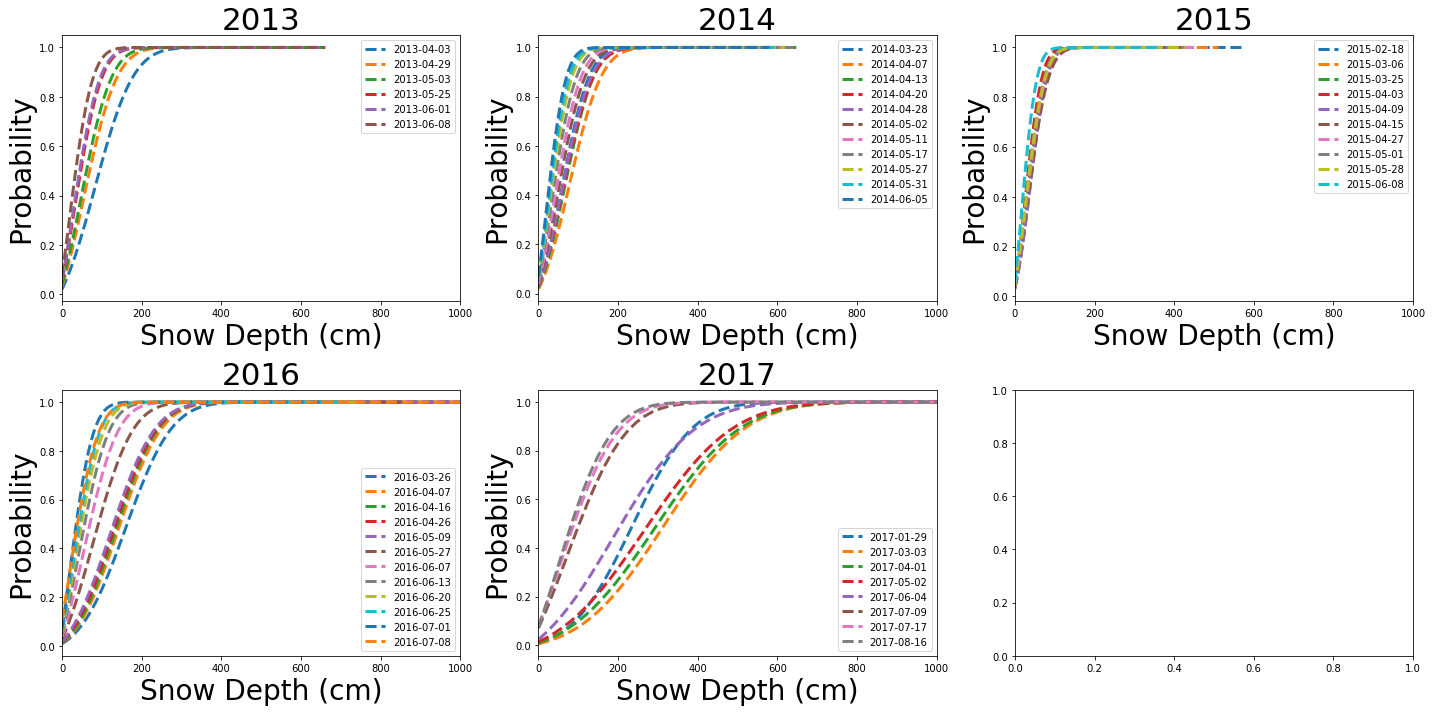

In [7]:
# ~~~ Annual CDF plots
fs_titles = 34
fs_labels = 30
fs_axes = 30
fs_text = 26
fs_legend = 30

n_bins=100

fig,axs=plt.subplots(2,3,figsize = (20, 10)) #make one figure, with axs (plot1, plot2, etc.)
flat_ax = axs.flat #flatten the axes (subplots)

for ii, year in enumerate(years):

    ax = flat_ax[ii] #which plot are you plotting
    

    startTime = pd.to_datetime("10-01-{}".format(year-1))
    endTime = pd.to_datetime("09-30-{}".format(year))

    current_df = date_df.loc[startTime:endTime] #buy pickles!

    for i,row in current_df.iterrows():

        f = row['filename']
        depth_array = np.loadtxt(f, skiprows=6) * 100 #cm
        bins,y = compute_cdf(depth_array, n_bins, mask_50m, np.max(mask_50m))

        ax.plot(bins, y,  linestyle='--', linewidth=3, label=str(i.date())) #color=cycle[i],
        ax.set_xlim(0,1000)
        ax.set_title('{}'.format(year), fontsize = fs_titles-3)
        ax.set_xlabel('Snow Depth (cm)', fontsize = fs_axes-2)
        ax.set_ylabel('Probability', fontsize = fs_axes-2)
        ax.legend()

plt.tight_layout()
# plt.savefig('/home/meganmason/Documents/projects/thesis/figures/working/50m_depth/annual_cdf_subplots.png', dpi=150)
plt.show()

  

In [8]:
# ~~~~CDF for one!

# fig, ax = plt.subplots(figsize=(8, 4))

# f = flist[45]
# print(f)
# n_bins = 1000
# label='sucess??'
# depth_array = np.loadtxt(f, skiprows=6)
# d = depth_array[[(mask_50m == 1) & (depth_array > 0)]]

# mu = np.nanmean(d)
# sigma = np.nanstd(d)

# hist, bins = np.histogram(d, bins=n_bins,density=True)
# y = norm.pdf(bins, mu, sigma).cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label=label)
